<a href="https://colab.research.google.com/github/farhan1503001/Generative-Deep-Learning-With-Tensorflow/blob/main/Variational%20Autoencoder/MNIST/Variational_Autoencoder(VAE)_using_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder(VAE)

**Importing Libraries**

In [33]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from IPython import display

# Hyperparameter Settings
 **We define our latent dimension and batch size**

In [34]:
Latent_dim=2
Batch_size=128

# Utility Function

In [35]:
def map_image(image,label):
  """
  Here we will normalize and reshape our image
  """
  image=tf.cast(image,dtype=tf.float32)
  image=image/255.0
  #now reshaping the image
  image=tf.reshape(image,(28,28,1))

  return image

def get_dataset(map_func,is_test=False):
  """
  In this function we will load the data and split it accordingly after preprocessing
  """
  if is_test==True:
    split_op='test'
  else:
    split_op='train'
  #Now load the data
  dataset=tfds.load(name='mnist',as_supervised=True,split=split_op)
  dataset=dataset.map(map_func)
  if is_test:
    dataset=dataset.batch(Batch_size)
  else:
    dataset=dataset.shuffle(1024).batch(Batch_size)

  return dataset

In [36]:
#Now just download the dataset
train_dataset=get_dataset(map_image)

# VAE MODEL CREATION

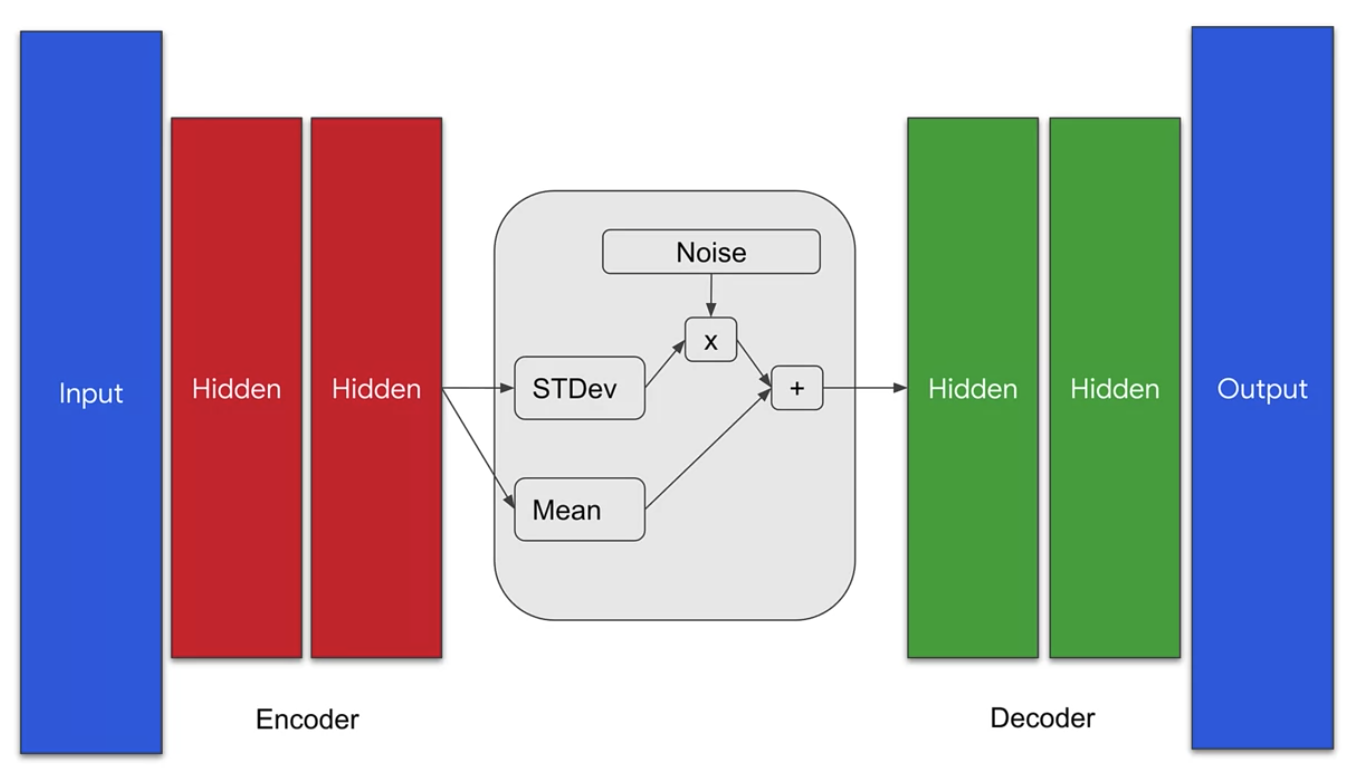

In [37]:
def encoder_layer(inputs,latent_dim):
  encode_conv1=keras.layers.Conv2D(filters=32,padding='same',strides=2,kernel_size=(3,3),activation='relu',name='en_conv1')(inputs)
  encode_batch1=keras.layers.BatchNormalization()(encode_conv1)
  #2nd conv
  encode_conv2=keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',strides=2,activation='relu',name='en_conv2')(encode_batch1)
  encode_batch2=keras.layers.BatchNormalization()(encode_conv2)
  #Now flatten out and dense layer
  encode_flatten=keras.layers.Flatten(name='encode_flatten')(encode_batch2)
  encode_dense1=keras.layers.Dense(units=20,activation='relu',name='encode_dense')(encode_flatten)
  encode_batch3=keras.layers.BatchNormalization()(encode_dense1)
  #Now sigma and mu layer with latent dimension
  sigma=keras.layers.Dense(units=latent_dim,name='latent_sigma')(encode_batch3)
  mu=keras.layers.Dense(units=latent_dim,name='latent_mu')(encode_batch3)

  return sigma,mu,encode_batch2.shape



**Now our sampling layer where we will mix gaussian noise**

In [38]:
class Sampling_layer(keras.layers.Layer):
  def call(self,inputs):
    """
    This function takes mu and std layer as input and adds random noises
    """
    sigma,mu=inputs
    batch=tf.shape(mu)[0]
    dim=tf.shape(mu)[1]
    #Now generating random gaussian noise
    epsilon=keras.backend.random_normal(shape=(batch,dim))

    return mu+tf.exp(0.5*sigma)*epsilon

**Now our complete Encoder Model Part**

In [39]:
def encoder_model(input_shape,latent_dim):
  """
  Here we will work on entire encoder model
  """
  inputs=keras.layers.Input(shape=input_shape)
  sigma,mu,conv_shape=encoder_layer(inputs,latent_dim)
  z=Sampling_layer()((sigma,mu))
  #Now defining our encoder model
  model=keras.Model(inputs=inputs,outputs=[sigma,mu,z])

  return model,conv_shape

# Decoder Layers of the Model

In [40]:
def decoder_layer(inputs,conv_shape):
  """
  Defines the decoder model
  latent_dim->Dimension of the latent space
  conv_shape-shape of encoder before flattening
  """
  units=conv_shape[1]*conv_shape[2]*conv_shape[3]
  x=keras.layers.Dense(units=units,activation='relu')(inputs)
  x=keras.layers.BatchNormalization(name='batch_norm')(x)
  #Now reshape to image
  x=keras.layers.Reshape(target_shape=(conv_shape[1],conv_shape[2],conv_shape[3]))(x)
  x=keras.layers.Conv2DTranspose(filters=64,kernel_size=3,strides=2,padding='same',activation='relu',name='dec_conv1')(x)
  x=keras.layers.BatchNormalization(name='dec_norm1')(x)
  x=keras.layers.Conv2DTranspose(filters=32,kernel_size=3,strides=2,padding='same',activation='relu',name='dec_conv2')(x)
  x=keras.layers.BatchNormalization(name='dec_norm2')(x)
  x=keras.layers.Conv2DTranspose(filters=1,kernel_size=3,strides=1,padding='same',activation='sigmoid',name='dec_conv3')(x)

  return x


**Decoder Model**

In [41]:
def decoder_model(latent_dim,conv_shape):
  """Here we will define our decoder model

  latent_dim: Latent dimension of latent space
  conv_shape: convolutional layer shape
  """
  inputs=keras.layers.Input(shape=(latent_dim,))

  outputs=decoder_layer(inputs,conv_shape)

  #Now declaring our decoder model
  model=keras.Model(inputs=inputs,outputs=outputs)

  return model


# Kullback Lieber Divergence Loss
**Here for improving the generative ability of model we have to take into account the random noise distribution at latent space**
**For that we need to introduce KLD loss function**

In [42]:
def kl_reconstruction_loss(inputs,outputs,mu,sigma):
  """
  Generate kl reconstruction loss 
  inputs:input batch
  outputs: output from the latent space
  mu-mean 
  sigma: standard deviation
  formula: mean(1+sigma-mean**2-e^sigma)*-0.5
  """
  kl_loss=1+sigma-tf.square(mu)-tf.math.exp(sigma)
  kl_loss=tf.reduce_mean(kl_loss)*-0.5

  return kl_loss


**VAE Model Creation**

In [43]:
def vae_model(encoder,decoder,input_shape):
  """
  Here from this model we will get our model
  """
  inputs=keras.layers.Input(shape=input_shape)
  #Feed the input to encoder
  sigma,mu,z=encoder(inputs)

  reconstructed=decoder(z)

  model=keras.Model(inputs=inputs,outputs=reconstructed)
  #Now add loss function
  loss=kl_reconstruction_loss(inputs,z,mu,sigma)
  model.add_loss(loss)

  return model


In [44]:
#First we have to create a model to gain encoder,decoder,sampling model
def get_models(input_shape,latent_dim):
  encoder,conv_shape=encoder_model(input_shape=input_shape,latent_dim=latent_dim)
  decoder=decoder_model(latent_dim,conv_shape)
  vae=vae_model(encoder,decoder,input_shape)

  return encoder,decoder,vae

In [45]:
# Get the encoder, decoder and 'master' model (called vae)
encoder, decoder, vae = get_models(input_shape=(28,28,1,), latent_dim=Latent_dim)

# Train the model

In [46]:
loss=keras.losses.BinaryCrossentropy()
loss_metric=keras.metrics.Mean()
optimizer=keras.optimizers.Adam()


**Visualization**

In [47]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """

  # generate images from the test input
  predictions = model.predict(test_input)

  # plot the results
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

**Train loop same as Pytorch**

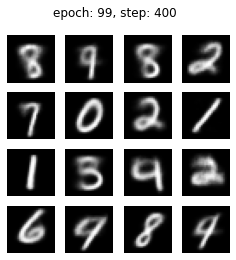

Epoch: 99 step: 400 mean loss = 141.37047


In [48]:
random_vector_generation=tf.random.normal(shape=[16,Latent_dim])
#Defining epochs
epochs=100
total_loss=0
#Now first image and reconstructed image
generate_and_save_images(decoder,0,0,random_vector_generation)
#Now we will start training
for epoch in range(epochs):
  print("Start of the epoch ",epoch)
  #iterate over the batches of the dataset
  for batch_index,images in enumerate(train_dataset):
    #Now everything will be under tape
    with tf.GradientTape() as tape:
      #Feed the batch to vae model
      reconstructed=vae(images)
      #Now we will calculate loss so flatt the hell out
      flatten_input=tf.reshape(images,shape=[-1])
      flatten_output=tf.reshape(reconstructed,shape=[-1])
      #Finding bce loss
      bce_loss=loss(flatten_input,flatten_output)*784
      #adding klloss
      total_loss=bce_loss+sum(vae.losses)
      #Now getting the gradients and updating the weights
      grads=tape.gradient(total_loss,vae.trainable_weights)
      optimizer.apply_gradients(grads_and_vars=zip(grads,vae.trainable_weights))

      #compute the metrics
      loss_metric(total_loss)
     #display outputs every 100 steps
      if batch_index % 100 == 0:
        display.clear_output(wait=False)    
        generate_and_save_images(decoder, epoch,batch_index,random_vector_generation)
        print('Epoch: %s step: %s mean loss = %s' % (epoch,batch_index, loss_metric.result().numpy()))      
        